In [ ]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence
from tqdm import tqdm

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Feature columns
feature_cols = [
    "year",
    "membership_year",
    "is_household",
    "vehicle_count",
    "vehicle_age_mean",
    "beløp",
    "gave_feedback",
    "mean_feedback",
    "age",
    "gender",
    "sentralitetsindex",
]

# Load the examples
train_examples = torch.load("all/train_examples.pt")
val_examples = torch.load("all/val_examples.pt")

In [3]:
# 4. Dataset & DataLoader
class ChurnDataset(Dataset):
    def __init__(self, examples):
        self.examples = examples

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, idx):
        seq, length, label = self.examples[idx]
        return seq, length, label


def collate_fn(batch):
    seqs, lengths, labels = zip(*batch)
    seqs_padded = pad_sequence(seqs, batch_first=True)  # [B, T, F]
    lengths = torch.tensor(lengths, dtype=torch.long)  # [B]
    labels = torch.tensor(labels, dtype=torch.long)  # [B]
    # make padding mask if you need it (not used by GRU directly)
    max_len = seqs_padded.size(1)
    attn_mask = (
        torch.arange(max_len).unsqueeze(0).expand(len(lengths), -1)
        >= lengths.unsqueeze(1)
    ).to(
        device
    )  # True==padding
    return (
        seqs_padded.to(device),
        lengths.to(device),
        attn_mask,
        labels.to(device),
    )


train_ds = ChurnDataset(train_examples)
val_ds = ChurnDataset(val_examples)
train_loader = DataLoader(train_ds, batch_size=512, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_ds, batch_size=512, shuffle=False, collate_fn=collate_fn)

In [4]:
# 5. Model
torch.manual_seed(42)


class GRUClassifier(nn.Module):
    def __init__(
        self,
        input_size: int,
        hidden_size: int = 64,
        num_layers: int = 2,
        num_classes: int = 3,
        bidirectional: bool = False,
        dropout: float = 0.0,
    ):
        super().__init__()
        self.gru = nn.GRU(
            input_size,
            hidden_size,
            num_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=dropout if num_layers > 1 else 0.0,
        )
        self.num_directions = 2 if bidirectional else 1
        self.fc = nn.Linear(hidden_size * self.num_directions, num_classes)

    def forward(self, x, lengths):
        # x: [B, T, F], lengths: [B]
        packed = pack_padded_sequence(
            x, lengths.cpu(), batch_first=True, enforce_sorted=False
        )
        packed_out, h_n = self.gru(packed)
        # h_n: [num_layers * num_directions, B, hidden_size]
        if self.num_directions == 2:
            # concat forward + backward of last layer
            h_out = torch.cat([h_n[-2], h_n[-1]], dim=1)
        else:
            h_out = h_n[-1]
        return self.fc(h_out)


# Instantiate
input_size = len(feature_cols)
hidden_size = 64
num_layers = 2
num_classes = 3
model = GRUClassifier(
    input_size, hidden_size, num_layers, num_classes, bidirectional=True, dropout=0.3
).to(device)

# Loss & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [5]:
import wandb

num_epochs = 100

wandb.init(project="churn", name="gru")


# 7. Training & evaluation loops
def train_epoch(model, loader, criterion, optimizer):
    model.train()
    total_loss, correct, total = 0.0, 0, 0
    loop = tqdm(loader, desc="Train")
    for seqs, lengths, attn_mask, labels in loop:
        optimizer.zero_grad()
        outputs = model(seqs, lengths)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * labels.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        loop.set_postfix(loss=loss.item(), acc=correct / total)
    return total_loss / total, correct / total


def eval_epoch(model, loader, criterion):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    loop = tqdm(loader, desc="Val")
    with torch.no_grad():
        for seqs, lengths, attn_mask, labels in loop:
            outputs = model(seqs, lengths)
            loss = criterion(outputs, labels)

            total_loss += loss.item() * labels.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            loop.set_postfix(loss=loss.item(), acc=correct / total)
    return total_loss / total, correct / total


# 8. Run training
for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)
    val_loss, val_acc = eval_epoch(model, val_loader, criterion)
    print(
        f"Epoch {epoch:>2d} | train_loss={train_loss:.4f}, train_acc={train_acc:.4f} | val_loss={val_loss:.4f}, val_acc={val_acc:.4f}"
    )

    # Log to wandb
    wandb.log(
        {
            "epoch": epoch,
            "train_loss": train_loss,
            "train_accuracy": train_acc,
            "val_loss": val_loss,
            "val_accuracy": val_acc,
        }
    )

wandb: Currently logged in as: junta to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Val: 100%|██████████| 147/147 [00:05<00:00, 28.81it/s, acc=0.545, loss=0.855]


Epoch  1 | train_loss=0.9351, train_acc=0.5327 | val_loss=0.9119, val_acc=0.5454


Val: 100%|██████████| 147/147 [00:06<00:00, 23.98it/s, acc=0.547, loss=0.847]


Epoch  2 | train_loss=0.9072, train_acc=0.5432 | val_loss=0.9021, val_acc=0.5466


Val: 100%|██████████| 147/147 [00:06<00:00, 23.96it/s, acc=0.547, loss=0.839]


Epoch  3 | train_loss=0.9010, train_acc=0.5441 | val_loss=0.8983, val_acc=0.5467


Val: 100%|██████████| 147/147 [00:05<00:00, 27.55it/s, acc=0.549, loss=0.846]


Epoch  4 | train_loss=0.8982, train_acc=0.5447 | val_loss=0.8964, val_acc=0.5495


Val: 100%|██████████| 147/147 [00:05<00:00, 28.80it/s, acc=0.546, loss=0.833]


Epoch  5 | train_loss=0.8961, train_acc=0.5467 | val_loss=0.8952, val_acc=0.5461


Val: 100%|██████████| 147/147 [00:05<00:00, 28.87it/s, acc=0.55, loss=0.831] 


Epoch  6 | train_loss=0.8942, train_acc=0.5468 | val_loss=0.8926, val_acc=0.5495


Val: 100%|██████████| 147/147 [00:05<00:00, 28.06it/s, acc=0.55, loss=0.828] 


Epoch  7 | train_loss=0.8921, train_acc=0.5483 | val_loss=0.8907, val_acc=0.5499


Val: 100%|██████████| 147/147 [00:06<00:00, 24.39it/s, acc=0.551, loss=0.833]


Epoch  8 | train_loss=0.8906, train_acc=0.5481 | val_loss=0.8944, val_acc=0.5506


Val: 100%|██████████| 147/147 [00:05<00:00, 27.38it/s, acc=0.55, loss=0.834] 


Epoch  9 | train_loss=0.8889, train_acc=0.5490 | val_loss=0.8885, val_acc=0.5499


Val: 100%|██████████| 147/147 [00:04<00:00, 29.94it/s, acc=0.553, loss=0.825]


Epoch 10 | train_loss=0.8860, train_acc=0.5496 | val_loss=0.8853, val_acc=0.5527


Val: 100%|██████████| 147/147 [00:05<00:00, 28.83it/s, acc=0.554, loss=0.823]


Epoch 11 | train_loss=0.8842, train_acc=0.5506 | val_loss=0.8823, val_acc=0.5541


Val: 100%|██████████| 147/147 [00:05<00:00, 24.85it/s, acc=0.552, loss=0.837]


Epoch 12 | train_loss=0.8819, train_acc=0.5516 | val_loss=0.8828, val_acc=0.5517


Val: 100%|██████████| 147/147 [00:05<00:00, 28.48it/s, acc=0.554, loss=0.826]


Epoch 13 | train_loss=0.8798, train_acc=0.5528 | val_loss=0.8808, val_acc=0.5544


Val: 100%|██████████| 147/147 [00:05<00:00, 27.29it/s, acc=0.556, loss=0.821]


Epoch 14 | train_loss=0.8782, train_acc=0.5534 | val_loss=0.8782, val_acc=0.5560


Val: 100%|██████████| 147/147 [00:05<00:00, 29.15it/s, acc=0.549, loss=0.818]


Epoch 15 | train_loss=0.8765, train_acc=0.5541 | val_loss=0.8794, val_acc=0.5492


Val: 100%|██████████| 147/147 [00:05<00:00, 28.46it/s, acc=0.555, loss=0.825]


Epoch 16 | train_loss=0.8760, train_acc=0.5546 | val_loss=0.8781, val_acc=0.5547


Val: 100%|██████████| 147/147 [00:04<00:00, 29.99it/s, acc=0.557, loss=0.817]


Epoch 17 | train_loss=0.8748, train_acc=0.5558 | val_loss=0.8779, val_acc=0.5567


Val: 100%|██████████| 147/147 [00:05<00:00, 28.72it/s, acc=0.558, loss=0.819]


Epoch 18 | train_loss=0.8739, train_acc=0.5560 | val_loss=0.8750, val_acc=0.5577


Val: 100%|██████████| 147/147 [00:05<00:00, 27.34it/s, acc=0.56, loss=0.82]  


Epoch 19 | train_loss=0.8727, train_acc=0.5566 | val_loss=0.8748, val_acc=0.5597


Val: 100%|██████████| 147/147 [00:05<00:00, 25.77it/s, acc=0.554, loss=0.823]


Epoch 20 | train_loss=0.8718, train_acc=0.5571 | val_loss=0.8752, val_acc=0.5543


Val: 100%|██████████| 147/147 [00:05<00:00, 29.19it/s, acc=0.555, loss=0.818]


Epoch 21 | train_loss=0.8712, train_acc=0.5572 | val_loss=0.8748, val_acc=0.5549


Val: 100%|██████████| 147/147 [00:05<00:00, 26.94it/s, acc=0.557, loss=0.818]


Epoch 22 | train_loss=0.8705, train_acc=0.5581 | val_loss=0.8744, val_acc=0.5570


Val: 100%|██████████| 147/147 [00:05<00:00, 25.34it/s, acc=0.557, loss=0.829]


Epoch 23 | train_loss=0.8699, train_acc=0.5584 | val_loss=0.8732, val_acc=0.5572


Val: 100%|██████████| 147/147 [00:05<00:00, 24.82it/s, acc=0.559, loss=0.819]


Epoch 24 | train_loss=0.8696, train_acc=0.5573 | val_loss=0.8725, val_acc=0.5589


Val: 100%|██████████| 147/147 [00:06<00:00, 23.85it/s, acc=0.559, loss=0.822]


Epoch 25 | train_loss=0.8685, train_acc=0.5587 | val_loss=0.8722, val_acc=0.5586


Val: 100%|██████████| 147/147 [00:06<00:00, 23.46it/s, acc=0.56, loss=0.816] 


Epoch 26 | train_loss=0.8681, train_acc=0.5584 | val_loss=0.8727, val_acc=0.5597


Val: 100%|██████████| 147/147 [00:05<00:00, 26.23it/s, acc=0.558, loss=0.818]


Epoch 27 | train_loss=0.8675, train_acc=0.5592 | val_loss=0.8723, val_acc=0.5584


Val: 100%|██████████| 147/147 [00:05<00:00, 28.97it/s, acc=0.558, loss=0.814]


Epoch 28 | train_loss=0.8673, train_acc=0.5591 | val_loss=0.8723, val_acc=0.5582


Val: 100%|██████████| 147/147 [00:05<00:00, 28.01it/s, acc=0.559, loss=0.821]


Epoch 29 | train_loss=0.8665, train_acc=0.5606 | val_loss=0.8728, val_acc=0.5594


Val: 100%|██████████| 147/147 [00:05<00:00, 25.80it/s, acc=0.559, loss=0.825]


Epoch 30 | train_loss=0.8661, train_acc=0.5599 | val_loss=0.8730, val_acc=0.5588


Val: 100%|██████████| 147/147 [00:05<00:00, 28.90it/s, acc=0.556, loss=0.83] 


Epoch 31 | train_loss=0.8656, train_acc=0.5608 | val_loss=0.8727, val_acc=0.5557


Val: 100%|██████████| 147/147 [00:05<00:00, 27.69it/s, acc=0.56, loss=0.818] 


Epoch 32 | train_loss=0.8654, train_acc=0.5606 | val_loss=0.8730, val_acc=0.5597


Val: 100%|██████████| 147/147 [00:04<00:00, 29.80it/s, acc=0.557, loss=0.817]


Epoch 33 | train_loss=0.8649, train_acc=0.5616 | val_loss=0.8727, val_acc=0.5566


Val: 100%|██████████| 147/147 [00:05<00:00, 25.13it/s, acc=0.558, loss=0.818]


Epoch 34 | train_loss=0.8645, train_acc=0.5613 | val_loss=0.8724, val_acc=0.5577


Val: 100%|██████████| 147/147 [00:05<00:00, 27.74it/s, acc=0.555, loss=0.818]


Epoch 35 | train_loss=0.8642, train_acc=0.5615 | val_loss=0.8730, val_acc=0.5553


Val: 100%|██████████| 147/147 [00:06<00:00, 23.43it/s, acc=0.559, loss=0.818]


Epoch 36 | train_loss=0.8636, train_acc=0.5618 | val_loss=0.8731, val_acc=0.5587


Val: 100%|██████████| 147/147 [00:05<00:00, 28.74it/s, acc=0.555, loss=0.813]


Epoch 37 | train_loss=0.8632, train_acc=0.5626 | val_loss=0.8720, val_acc=0.5552


Val: 100%|██████████| 147/147 [00:05<00:00, 27.12it/s, acc=0.557, loss=0.817]


Epoch 38 | train_loss=0.8629, train_acc=0.5623 | val_loss=0.8714, val_acc=0.5571


Val: 100%|██████████| 147/147 [00:05<00:00, 28.93it/s, acc=0.556, loss=0.818]


Epoch 39 | train_loss=0.8621, train_acc=0.5637 | val_loss=0.8712, val_acc=0.5559


Val: 100%|██████████| 147/147 [00:05<00:00, 29.14it/s, acc=0.556, loss=0.818]


Epoch 40 | train_loss=0.8623, train_acc=0.5628 | val_loss=0.8725, val_acc=0.5563


Val: 100%|██████████| 147/147 [00:02<00:00, 55.04it/s, acc=0.555, loss=0.811]


Epoch 41 | train_loss=0.8617, train_acc=0.5635 | val_loss=0.8722, val_acc=0.5554


Val: 100%|██████████| 147/147 [00:02<00:00, 57.82it/s, acc=0.56, loss=0.82]  


Epoch 42 | train_loss=0.8609, train_acc=0.5643 | val_loss=0.8731, val_acc=0.5596


Val: 100%|██████████| 147/147 [00:02<00:00, 54.20it/s, acc=0.559, loss=0.809]


Epoch 43 | train_loss=0.8609, train_acc=0.5642 | val_loss=0.8730, val_acc=0.5588


Val: 100%|██████████| 147/147 [00:02<00:00, 53.77it/s, acc=0.554, loss=0.809]


Epoch 44 | train_loss=0.8601, train_acc=0.5646 | val_loss=0.8736, val_acc=0.5536


Val: 100%|██████████| 147/147 [00:03<00:00, 43.41it/s, acc=0.556, loss=0.813]


Epoch 45 | train_loss=0.8599, train_acc=0.5660 | val_loss=0.8725, val_acc=0.5562


Val: 100%|██████████| 147/147 [00:03<00:00, 41.41it/s, acc=0.555, loss=0.821]


Epoch 46 | train_loss=0.8589, train_acc=0.5659 | val_loss=0.8734, val_acc=0.5553


Val: 100%|██████████| 147/147 [00:02<00:00, 54.19it/s, acc=0.556, loss=0.814]


Epoch 47 | train_loss=0.8593, train_acc=0.5654 | val_loss=0.8726, val_acc=0.5561


Val: 100%|██████████| 147/147 [00:05<00:00, 24.88it/s, acc=0.557, loss=0.817]


Epoch 48 | train_loss=0.8585, train_acc=0.5668 | val_loss=0.8744, val_acc=0.5571


Val: 100%|██████████| 147/147 [00:04<00:00, 29.43it/s, acc=0.557, loss=0.816]


Epoch 49 | train_loss=0.8581, train_acc=0.5672 | val_loss=0.8734, val_acc=0.5573


Val: 100%|██████████| 147/147 [00:04<00:00, 29.55it/s, acc=0.556, loss=0.811]


Epoch 50 | train_loss=0.8573, train_acc=0.5667 | val_loss=0.8732, val_acc=0.5559


Val: 100%|██████████| 147/147 [00:05<00:00, 29.34it/s, acc=0.556, loss=0.814]


Epoch 51 | train_loss=0.8572, train_acc=0.5682 | val_loss=0.8738, val_acc=0.5558


Train:  52%|█████▏    | 306/588 [00:14<00:13, 21.01it/s, acc=0.567, loss=0.878]


KeyboardInterrupt: 

ROC AUC Score (OvR): 0.7443

Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.65      0.57     21127
           1       0.68      0.60      0.64     34706
           2       0.43      0.38      0.40     19394

    accuracy                           0.56     75227
   macro avg       0.54      0.54      0.54     75227
weighted avg       0.56      0.56      0.56     75227



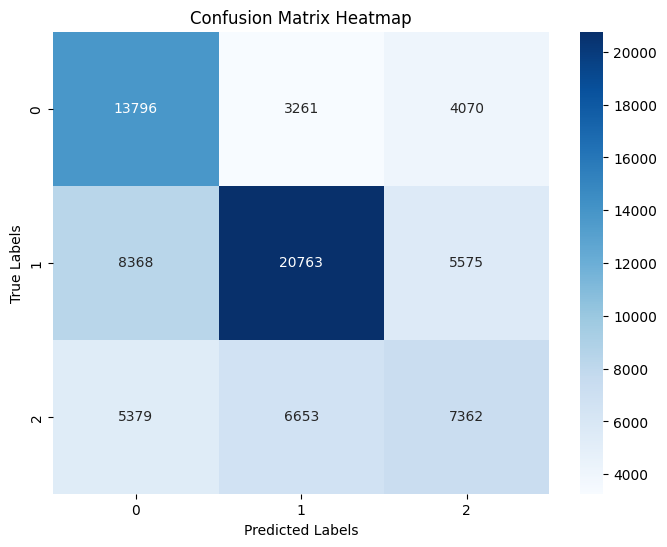

In [ ]:
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1. Collect all true labels and predicted probabilities
model.eval()
all_labels = []
all_preds = []
all_probs = []

with torch.no_grad():
    for seqs, lengths, attn_mask, labels in tqdm(
        val_loader, desc="Collecting predictions"
    ):
        outputs = model(seqs, lengths)
        probs = torch.softmax(outputs, dim=1)
        preds = outputs.argmax(dim=1)

        all_labels.append(labels.cpu().numpy())
        all_preds.append(preds.cpu().numpy())
        all_probs.append(probs.cpu().numpy())

all_labels = np.concatenate(all_labels)
all_preds = np.concatenate(all_preds)
all_probs = np.concatenate(all_probs)

# 2. ROC AUC Score (one-vs-rest for multiclass)
roc_auc = roc_auc_score(all_labels, all_probs, multi_class="ovr")
print(f"ROC AUC Score (OvR): {roc_auc:.4f}")

# 3. Classification Report
report = classification_report(all_labels, all_preds)
print("\nClassification Report:\n", report)

# 4. Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix Heatmap")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [20]:
from scipy.stats import binomtest

n = 75227
correct = 42126
p_random = 1/3  # under H0

p_value = binomtest(correct, n, p=p_random, alternative='greater')
print(f"p-value: {p_value.pvalue}")


p-value: 0.0


In [19]:
from scipy.stats import chisquare

# Example: predicted class distribution from your confusion matrix
# (you'll need actual predicted class counts here, below are dummy values)
pred_counts = [27500, 31000, 16727]
expected_counts = [21127, 34706, 19394]  # true class counts

chi2, p_value = chisquare(pred_counts, f_exp=expected_counts)
print(f"Chi-square test p-value: {p_value:.6f}")


Chi-square test p-value: 0.000000
